In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from sklearn import preprocessing, model_selection, linear_model, tree, ensemble, metrics, feature_selection, neighbors
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from scipy import stats
from xgboost import XGBRegressor

In [3]:
RANDOM_STATE = 1234
np.random.seed = RANDOM_STATE

# Uvod

Baza podataka "Black Friday Sales" sadrži podatke o kupovini u toku Crnog Petka. To je dan nakon Dana zahvalnosti i tada su veliki popusti i rasprodaje garderobe, elektronskih uređaja, itd. Veliki broj ljudi ide u kupovinu i troši više novca nego inače.

Analizom ponašanja potrošača, odnosno proučavanjem uticaja faktora kao što su starost, pol i lokacija na potrošačke navike, omogućava kompanijama da bolje kreiraju svoje marketinške strategije. Predviđanjem iznosa kupovina one mogu bolje da upravljaju zalihama i da odrede ciljane promocije tokom budućih rasprodaja.
To ćemo postići primenom mašinskog učenja. Glavni cilj je kreirati što bolji model na osnovu kog ćemo izvršiti predviđanje.

# Učitavanje podataka

In [4]:
data = pd.read_csv('Black Friday Dataset.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [6]:
data.shape

(550068, 12)

Baza sadrži informacije o preko 500.000 kupaca. Ona ima 12 kolona, od kojih su pet kategoričke, a ostale su numeričke. One nose sledeće informacije:

User_ID:                    Jedinstveni ID potrošača. \
Product_ID:                 Jedinstveni ID proizvoda. \
Gender:                     Pol potrošača. \
Age:                        Starosna grupa kojoj pripada potrošač. \
Occupation:                 Zanimanje potrošača. \
City_Category:              Kategorija grada potrošača. \
Stay_In_Current_City_Years: Broj godina koliko potrošač živi u tom gradu. \
Marital_Status:             Bračni status. \
Product_Category_1 to _3:   Kategorije proizvoda. \
Purchase:                   Iznos kupovine. 

# Preprocesiranje

Za početak treba srediti bazu.

In [7]:
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


Izbacujemo kolone 'User_ID' i 'Product_ID' jer one nemaju nikakvog uticaja na ishod kupovine.

In [8]:
data.drop(['User_ID','Product_ID'], axis=1, inplace=True)

U kolonama 'Age' i 'Stay_In_Current_City_Years' se javljaju plusevi koje ćemo ukloniti.

In [9]:
data['Age'] = data['Age'].str.strip('+')
data['Stay_In_Current_City_Years'] = data['Stay_In_Current_City_Years'].str.strip('+')

In [10]:
data.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,M,55,16,C,4,0,8,NaN,NaN,7969


### Nedostajuće vrednosti

In [11]:
pd.DataFrame({'Nedostajuće vrdnosti': data.isnull().sum(), 'Procenat nedostajućih vrednosti': data.isnull().sum() / data.shape[0]*100})

,Nedostajuće vrdnosti,Procenat nedostajućih vrednosti
Gender,0,0.000000
Age,0,0.000000
Occupation,0,0.000000
City_Category,0,0.000000
Stay_In_Current_City_Years,0,0.000000
Marital_Status,0,0.000000
Product_Category_1,0,0.000000
Product_Category_2,173638,31.566643
Product_Category_3,383247,69.672659
Purchase,0,0.000000


Skoro 70% podataka u koloni 'Product_Category_3' nedostaje pa ćemo je iz tog razloga ukloniti. Dok u koloni 'Product_Category_2' nedostajuće vrednosti dopunjavamo medijanom.

In [12]:
data.drop('Product_Category_3', axis=1, inplace=True)

In [13]:
data['Product_Category_2'] = data['Product_Category_2'].fillna(data['Product_Category_2'].median())

In [14]:
data.isnull().sum()

Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Purchase                      0
dtype: int64

### Transformisanje kategoričkih atributa u numeričke

Radi kasnije analize i modeliranja, kategoričke promenljive pretvaramo u numeričke.

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Gender                      550068 non-null  object 
 1   Age                         550068 non-null  object 
 2   Occupation                  550068 non-null  int64  
 3   City_Category               550068 non-null  object 
 4   Stay_In_Current_City_Years  550068 non-null  object 
 5   Marital_Status              550068 non-null  int64  
 6   Product_Category_1          550068 non-null  int64  
 7   Product_Category_2          550068 non-null  float64
 8   Purchase                    550068 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 37.8+ MB


In [16]:
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender'])  
data['Age'] = le.fit_transform(data['Age'])        
data['City_Category'] = le.fit_transform(data['City_Category'])
data['Stay_In_Current_City_Years'] = pd.to_numeric(data.Stay_In_Current_City_Years)

In [17]:
data.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase
0,0,0,10,0,2,0,3,9.0,8370
1,0,0,10,0,2,0,1,6.0,15200
2,0,0,10,0,2,0,12,9.0,1422
3,0,0,10,0,2,0,12,14.0,1057
4,1,6,16,2,4,0,8,9.0,7969


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Gender                      550068 non-null  int32  
 1   Age                         550068 non-null  int32  
 2   Occupation                  550068 non-null  int64  
 3   City_Category               550068 non-null  int32  
 4   Stay_In_Current_City_Years  550068 non-null  int64  
 5   Marital_Status              550068 non-null  int64  
 6   Product_Category_1          550068 non-null  int64  
 7   Product_Category_2          550068 non-null  float64
 8   Purchase                    550068 non-null  int64  
dtypes: float64(1), int32(3), int64(5)
memory usage: 31.5 MB


### Osnovne statističke informacije

In [19]:
data.describe()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase
count,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000
mean,0.753105,2.496430,8.076707,1.042640,1.858418,0.409653,5.404270,9.576434,9263.968713
std,0.431205,1.353632,6.522660,0.760211,1.289443,0.491770,3.936211,4.226025,5023.065394
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,12.000000
25%,1.000000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,8.000000,5823.000000
50%,1.000000,2.000000,7.000000,1.000000,2.000000,0.000000,5.000000,9.000000,8047.000000
75%,1.000000,3.000000,14.000000,2.000000,3.000000,1.000000,8.000000,14.000000,12054.000000
max,1.000000,6.000000,20.000000,2.000000,4.000000,1.000000,20.000000,18.000000,23961.000000


### Korelacija

<Axes: >

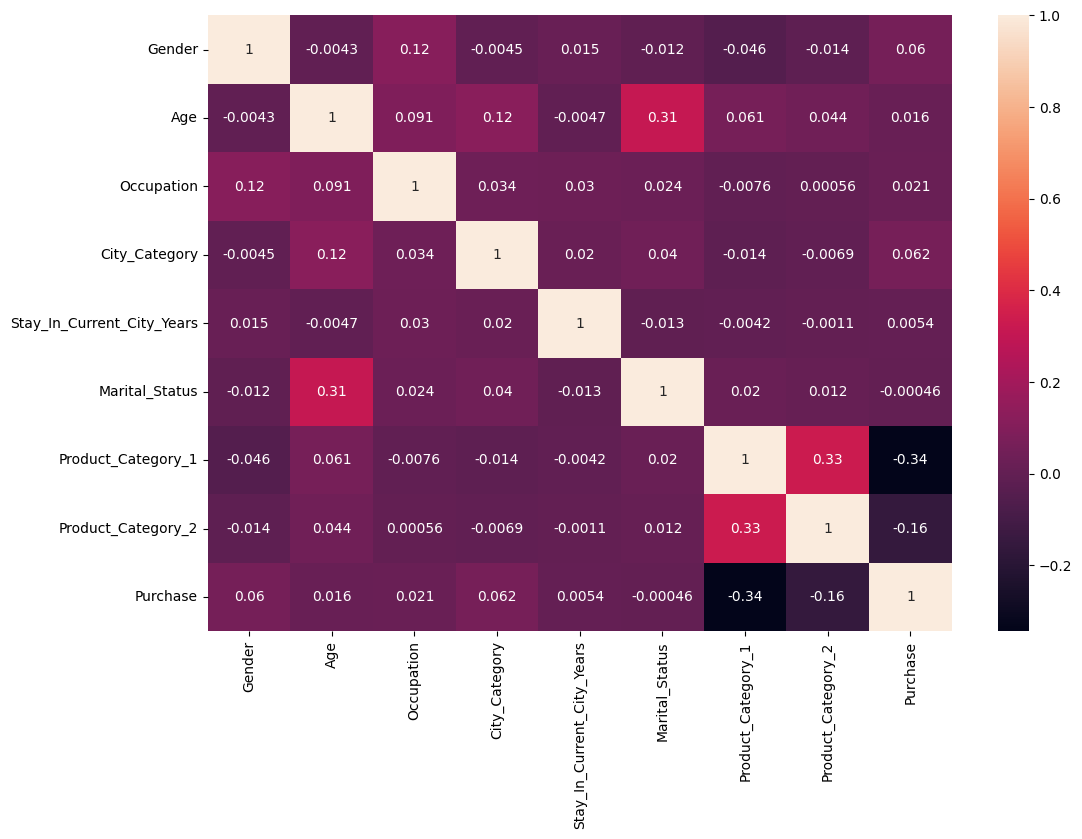

In [20]:
plt.figure(figsize=(12, 8))

sns.heatmap(
    data.corr(),
    annot=True
)

# Vizuelizacija podataka

array([[<Axes: title={'center': 'Gender'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Occupation'}>],
       [<Axes: title={'center': 'City_Category'}>,
        <Axes: title={'center': 'Stay_In_Current_City_Years'}>,
        <Axes: title={'center': 'Marital_Status'}>],
       [<Axes: title={'center': 'Product_Category_1'}>,
        <Axes: title={'center': 'Product_Category_2'}>,
        <Axes: title={'center': 'Purchase'}>]], dtype=object)

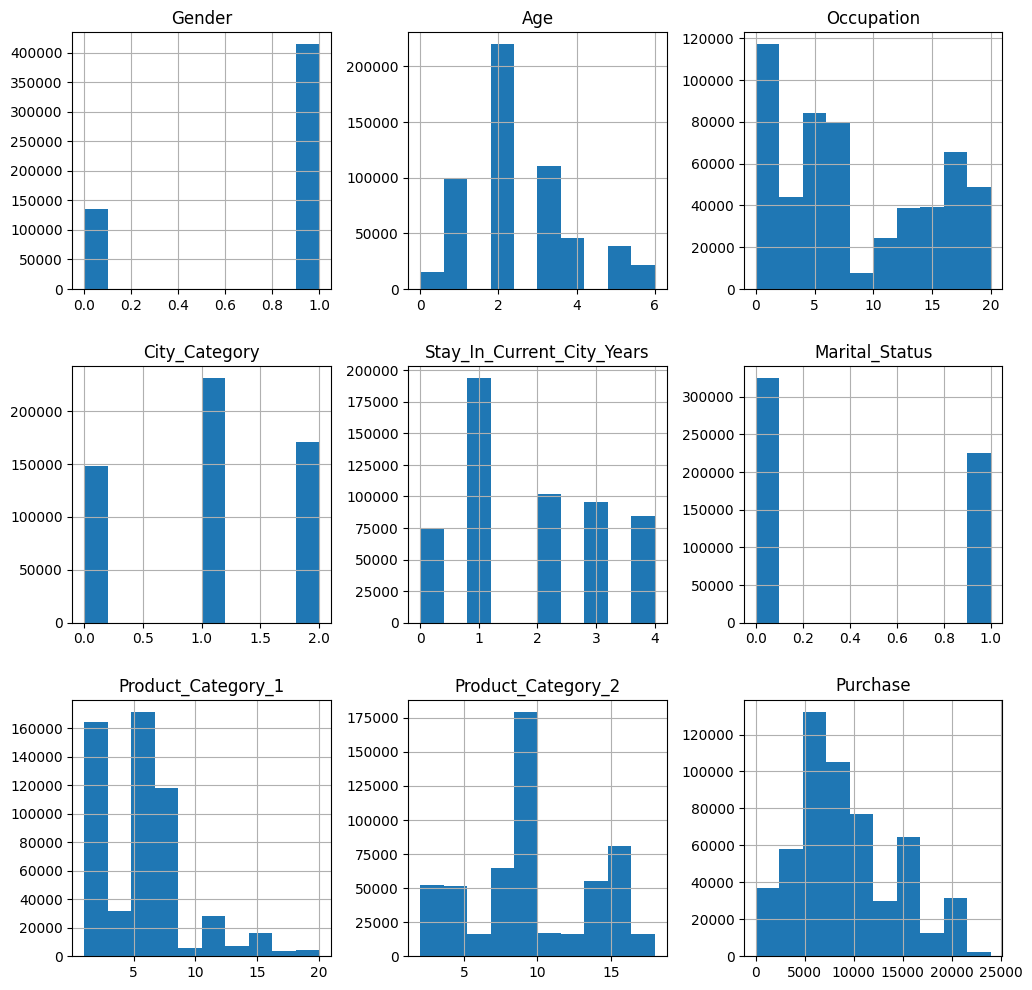

In [21]:
data.hist(figsize=(12,12))

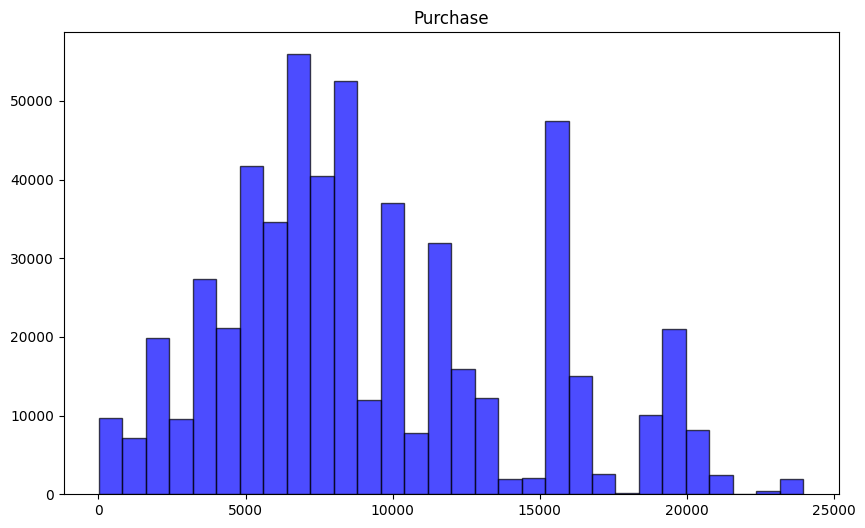

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(data['Purchase'], bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Purchase')
plt.show() 

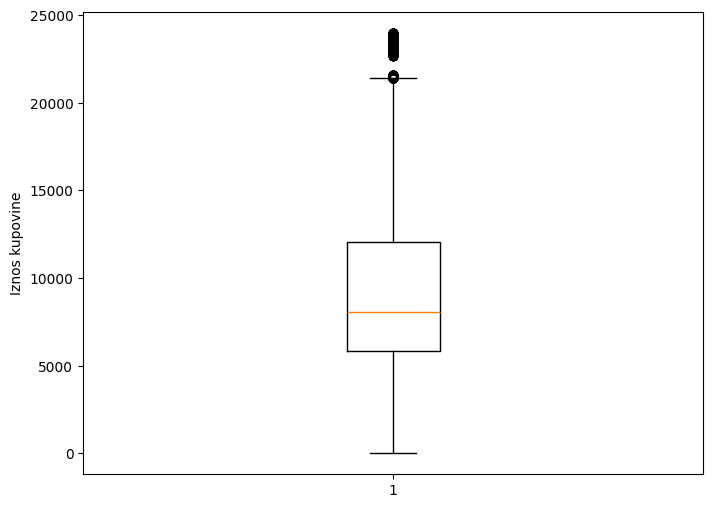

In [23]:
plt.figure(figsize=(8, 6))
plt.boxplot(data['Purchase'])
plt.ylabel('Iznos kupovine')
plt.show()

### Prosečna potrošnja po polu

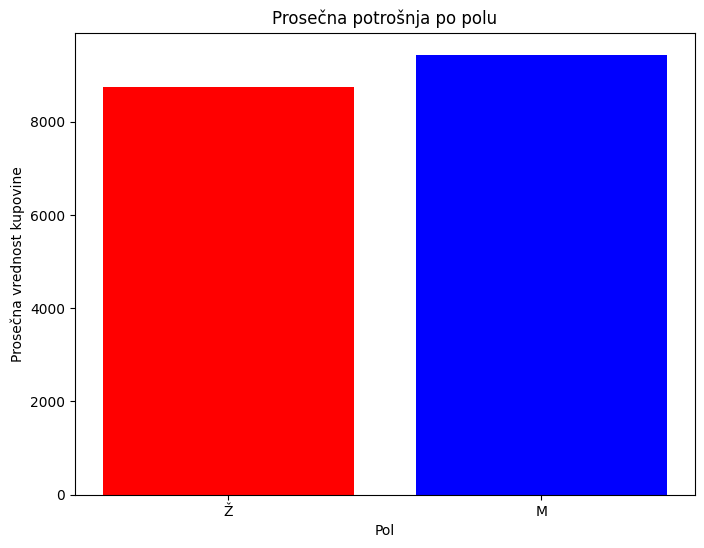

In [24]:
plt.figure(figsize=(8, 6))
plt.bar(['Ž', 'M'], data.groupby('Gender')['Purchase'].mean().values, color=['red', 'blue'])
plt.title('Prosečna potrošnja po polu')
plt.xlabel('Pol')
plt.ylabel('Prosečna vrednost kupovine')
plt.show()

### Prosečna potrošnja po gradu

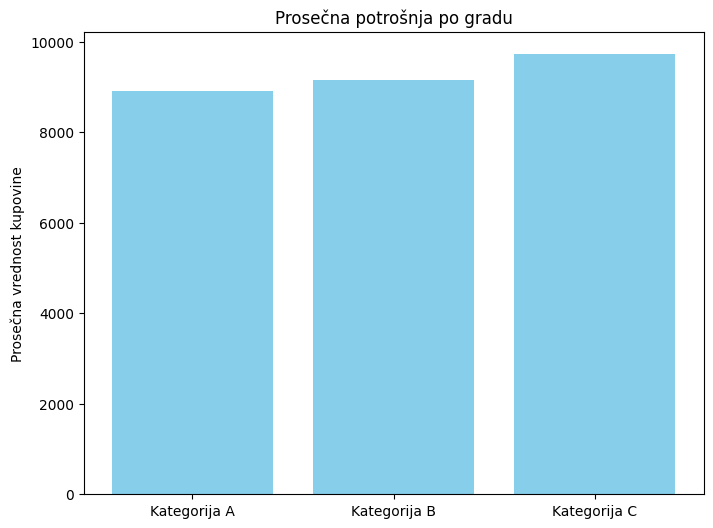

In [25]:
plt.figure(figsize=(8, 6))
plt.bar(['Kategorija A', 'Kategorija B', 'Kategorija C'], data.groupby('City_Category')['Purchase'].mean().values, color='skyblue')
plt.title('Prosečna potrošnja po gradu')
plt.ylabel('Prosečna vrednost kupovine')
plt.show()

### Prosečna potrošnja po starosnim grupama

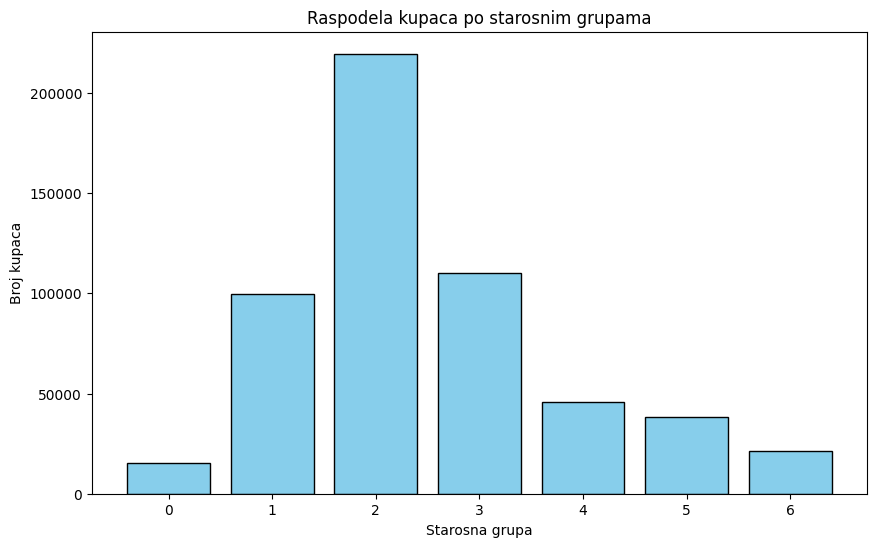

In [26]:
plt.figure(figsize=(10, 6))
plt.bar(data['Age'].value_counts().sort_index().index, data['Age'].value_counts().sort_index().values, color='skyblue', edgecolor='black')
plt.title('Raspodela kupaca po starosnim grupama')
plt.xlabel('Starosna grupa')
plt.ylabel('Broj kupaca')
plt.xticks(rotation=0)
plt.show()

0: 0-17\
1: 18-25\
2: 26-35\
3: 36-45\
4: 46-50\
5: 51-55\
6: 55+

Vidimo da je najviše kupaca starosti od 26-35 godina.

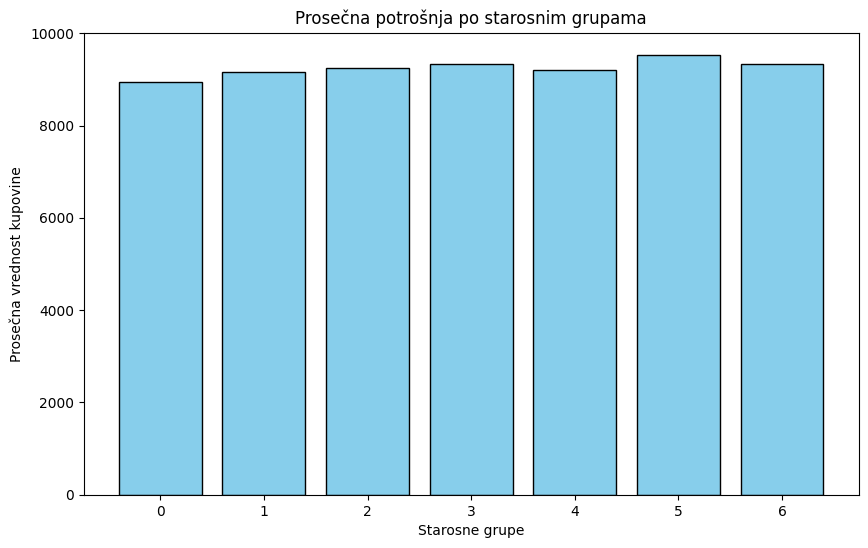

In [27]:
plt.figure(figsize=(10, 6))
plt.bar(data.groupby('Age')['Purchase'].mean().sort_index().reset_index()['Age'], data.groupby('Age')['Purchase'].mean().sort_index().reset_index()['Purchase'], color='skyblue', edgecolor='black')
plt.xlabel('Starosne grupe')
plt.ylabel('Prosečna vrednost kupovine')
plt.title('Prosečna potrošnja po starosnim grupama')
plt.xticks(rotation=0)
plt.show()

### Prosečna potrošnja po kategorijama prozivoda

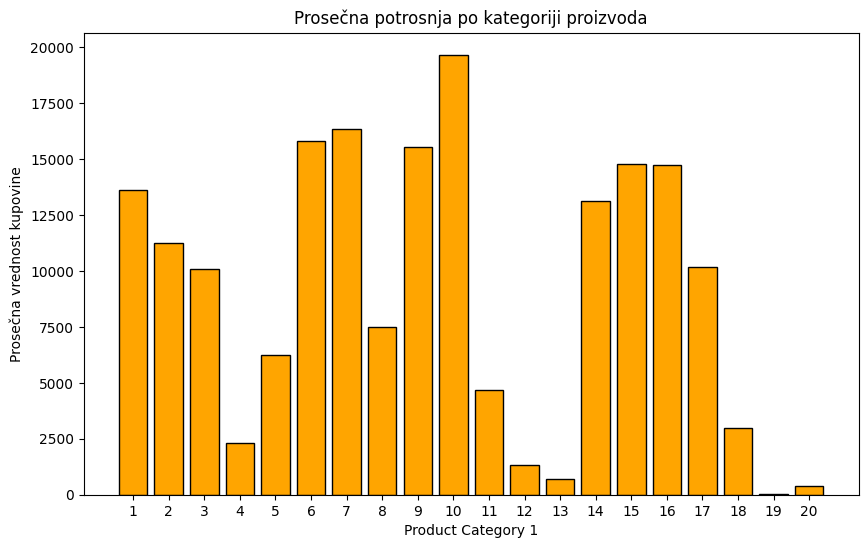

In [28]:
plt.figure(figsize=(10, 6))
plt.bar(data.groupby('Product_Category_1')['Purchase'].mean().reset_index()['Product_Category_1'].astype(str), data.groupby('Product_Category_1')['Purchase'].mean().reset_index()['Purchase'], color='orange', edgecolor='black')
plt.title('Prosečna potrosnja po kategoriji proizvoda')
plt.xlabel('Product Category 1')
plt.ylabel('Prosečna vrednost kupovine')
plt.show()

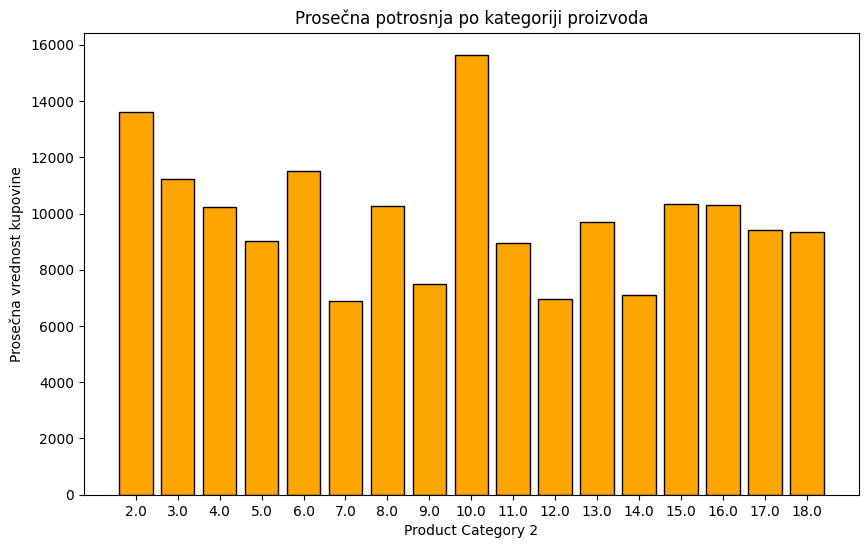

In [29]:
plt.figure(figsize=(10, 6))
plt.bar(data.groupby('Product_Category_2')['Purchase'].mean().reset_index()['Product_Category_2'].astype(str), data.groupby('Product_Category_2')['Purchase'].mean().reset_index()['Purchase'], color='orange', edgecolor='black')
plt.title('Prosečna potrosnja po kategoriji proizvoda')
plt.xlabel('Product Category 2')
plt.ylabel('Prosečna vrednost kupovine')
plt.show()

### Raspodela kupaca po zanimanjima

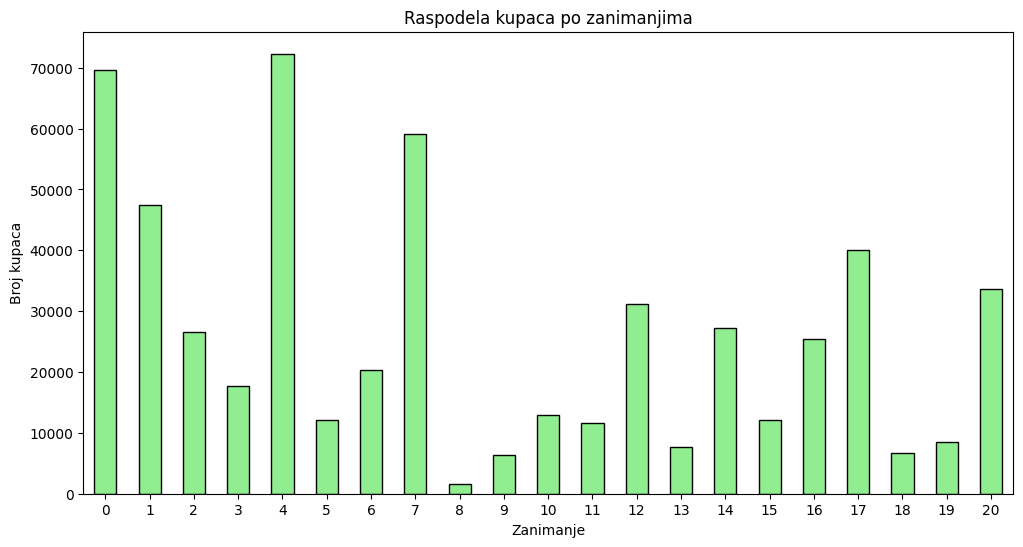

In [30]:
plt.figure(figsize=(12, 6))
data['Occupation'].value_counts().sort_index().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Raspodela kupaca po zanimanjima')
plt.xlabel('Zanimanje')
plt.ylabel('Broj kupaca')
plt.xticks(rotation=0)
plt.show()

# Kreiranje modela

In [31]:
X = data.drop('Purchase', axis=1)
y = data['Purchase']

In [32]:
X.shape, y.shape

((550068, 8), (550068,))

## Podela podataka

In [33]:
X_train_validation, x_test, y_train_validation, y_test = \
model_selection.train_test_split(X, y, test_size=0.33, random_state=RANDOM_STATE)
x_train, x_validation, y_train, y_validation =\
    model_selection.train_test_split(X_train_validation, y_train_validation, test_size=0.2, random_state=RANDOM_STATE)



## Skaliranje podataka

In [34]:
scaler = preprocessing.StandardScaler()
scaler.fit(x_train, y_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

## Modeli

### Linearna Regresija

In [35]:
lr = linear_model.LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [36]:
lr.intercept_, lr.coef_

(9266.499321656785,
 array([  216.1417976 ,   167.76235987,    56.09128786,   260.90644483,
            7.68774602,   -25.42431959, -1646.63039762,  -245.09085987]))

In [37]:
y_predicted = lr.predict(x_test)

In [38]:
mae_lr, mse_lr, r2_lr = metrics.mean_absolute_error(y_test, y_predicted), metrics.mean_squared_error(y_test, y_predicted), metrics.r2_score(y_test, y_predicted)

In [39]:
mae_lr, mse_lr, r2_lr

(3585.504991604476, 21952816.894601766, 0.12619019047998092)

#### Rekurzivna eliminacija atributa

In [40]:
rfe = feature_selection.RFE(lr, n_features_to_select=5, verbose=2)
rfe.fit(x_train, y_train)

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.


RFE(estimator=LinearRegression(), n_features_to_select=5, verbose=2)

In [41]:
rfe.support_

array([ True,  True, False,  True, False, False,  True,  True])

In [42]:
x_train_1 = rfe.transform(x_train)
x_test_1 = rfe.transform(x_test)
x_train_1.shape, x_test_1.shape

((294836, 5), (181523, 5))

In [43]:
lr1 = linear_model.LinearRegression()
lr1.fit(x_train_1, y_train)

LinearRegression()

In [44]:
y_predicted_1 = lr1.predict(x_test_1)
mae_rfe, mse_rfe, r2_rfe = metrics.mean_absolute_error(y_test, y_predicted_1), metrics.mean_squared_error(y_test, y_predicted_1), metrics.r2_score(y_test, y_predicted_1)

In [45]:
mae_rfe, mse_rfe, r2_rfe

(3585.1738893035704, 21952716.91465537, 0.12619417008124745)

#### Log transformacija

Kako raspodela ciljne promenljive nije normalna, probaćemo logaritmovanjem da podatke približimo normalnoj rapodeli. Upravo iz razloga što linearni modeli pretpostavljaju da su odstupanja (greske) normalno raspodeljena.

In [46]:
y_log = np.log(data['Purchase'] + 1)

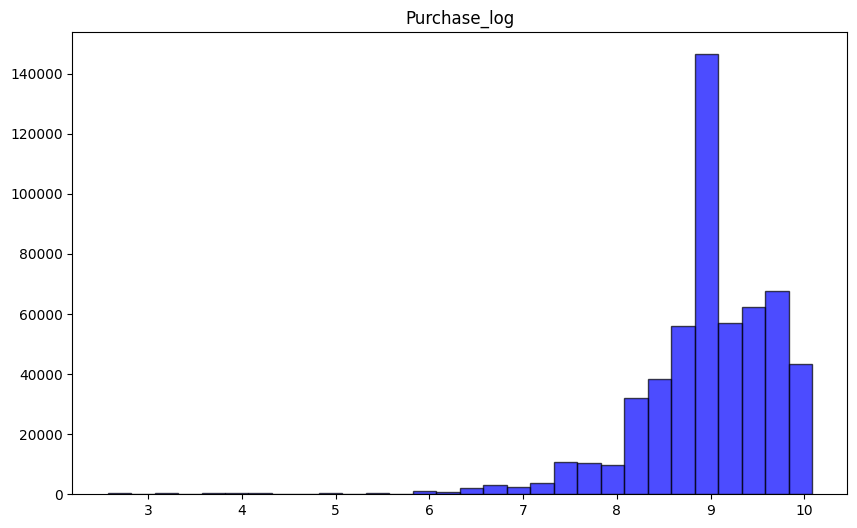

In [47]:
plt.figure(figsize=(10, 6))
plt.hist(np.log(data['Purchase'] + 1), bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Purchase_log')
plt.show() 

In [48]:
x_train_log, x_test_log, y_train_log, y_test_log = model_selection.train_test_split(X, y_log, test_size=0.3, random_state=RANDOM_STATE)
x_train_log.shape, x_test_log.shape, y_train_log.shape, y_test_log.shape

((385047, 8), (165021, 8), (385047,), (165021,))

In [49]:
scaler = preprocessing.StandardScaler()
scaler.fit(x_train_log, y_train_log)
x_train_log = scaler.transform(x_train_log)
x_test_log = scaler.transform(x_test_log)

In [50]:
lr = linear_model.LinearRegression()
lr.fit(x_train_log, y_train_log)

y_predicted_log = lr.predict(x_test_log)
y_predicted = np.exp(y_predicted_log) - 1

In [51]:
mae_log, mse_log, r2_log = metrics.mean_absolute_error(np.exp(y_test_log) - 1, y_predicted), metrics.mean_squared_error(np.exp(y_test_log) - 1, y_predicted), metrics.r2_score(np.exp(y_test_log) - 1, y_predicted)

In [52]:
mae_log, mse_log, r2_log

(3431.2833518994285, 22468709.157503154, 0.10545699661759445)

#### Ridge i Lasso regresija

In [53]:
rmodel = linear_model.Ridge(alpha=10) 
rmodel.fit(x_train, y_train)

Ridge(alpha=10)

In [54]:
mae_ridge, mse_ridge, r2_ridge = metrics.mean_absolute_error(y_train, rmodel.predict(x_train)), metrics.mean_squared_error(y_train, rmodel.predict(x_train)), rmodel.score(x_test, y_test)

In [55]:
mae_ridge, mse_ridge, r2_ridge

(3593.435487516488, 22054287.290156115, 0.12619024014480718)

In [56]:
rmodel.intercept_, rmodel.coef_

(9266.499321656785,
 array([  216.13699058,   167.75359752,    56.09125193,   260.89935175,
            7.68787036,   -25.42167635, -1646.57070392,  -245.10206096]))

In [57]:
lmodel = linear_model.Lasso(alpha=0.1)
lmodel.fit(x_train, y_train)

Lasso(alpha=0.1)

In [58]:
mae_lasso, mse_lasso, r2_lasso = metrics.mean_absolute_error(y_train, lmodel.predict(x_train)), metrics.mean_squared_error(y_train, lmodel.predict(x_train)), lmodel.score(x_test, y_test)

In [59]:
mae_lasso, mse_lasso, r2_lasso

(3593.4349088312756, 22054287.36326332, 0.12619058412181994)

In [60]:
lmodel.intercept_, lmodel.coef_ 

(9266.499321656785,
 array([  216.05678888,   167.62707432,    56.01589524,   260.82325857,
            7.59412538,   -25.28131144, -1646.5582082 ,  -245.01242483]))

In [61]:
emodel = linear_model.ElasticNet(alpha=0.75, l1_ratio=0.5)
emodel.fit(x_train, y_train)

ElasticNet(alpha=0.75)

In [62]:
mae_en, mse_en, r2_en = metrics.mean_absolute_error(y_train, emodel.predict(x_train)), metrics.mean_squared_error(y_train, emodel.predict(x_train)), emodel.score(x_test, y_test)

In [63]:
mae_en, mse_en, r2_en

(3681.789225020642, 22264669.90581223, 0.11823982359101448)

In [64]:
emodel.intercept_, emodel.coef_ 

(9266.499321656785,
 array([  171.87353356,   105.01963136,    51.53315885,   199.39129935,
            7.71066558,    -9.4759328 , -1186.73299412,  -287.55172983]))

#### Evaluacija

In [65]:
evaluacija = {
    "Tip": ["lr", "rfe", "log", "ridge", "lasso", "en"],
    "MAE": [mae_lr, mae_rfe, mae_log, mae_ridge, mae_lasso, mae_en],
    "MSE": [mse_lr, mse_rfe, mse_log, mse_ridge, mse_lasso, mse_en],
    "R²": [r2_lr, r2_rfe, r2_log, r2_ridge, r2_lasso, r2_en]
}

df = pd.DataFrame(evaluacija)
df.round(3)

,Tip,MAE,MSE,R²
0,lr,3585.505,2.195282e+07,0.126
1,rfe,3585.174,2.195272e+07,0.126
2,log,3431.283,2.246871e+07,0.105
3,ridge,3593.435,2.205429e+07,0.126
4,lasso,3593.435,2.205429e+07,0.126
5,en,3681.789,2.226467e+07,0.118


### Decision Tree

In [66]:
dt = tree.DecisionTreeRegressor(random_state = RANDOM_STATE)
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)

In [67]:
mae_dt, mse_dt, r2_dt = metrics.mean_absolute_error(y_test, y_pred), metrics.mean_squared_error(y_test, y_pred), metrics.r2_score(y_test, y_pred)

In [68]:
mae_dt, mse_dt, r2_dt

(2304.632917171272, 10378335.821782509, 0.586900774916199)

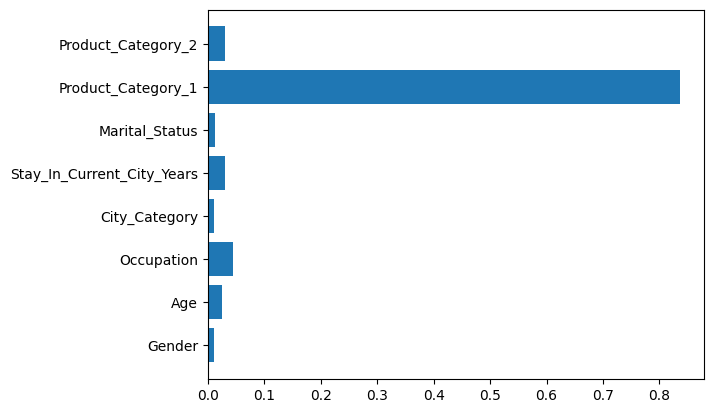

In [69]:
plt.barh(list(X.columns), dt.feature_importances_)
plt.show()

### Random Forest

In [70]:
rf = ensemble.RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

In [71]:
mae_rf, mse_rf, r2_rf = metrics.mean_absolute_error(y_test, y_pred), metrics.mean_squared_error(y_test, y_pred), metrics.r2_score(y_test, y_pred)

In [72]:
mae_rf, mse_rf, r2_rf

(2221.5712817343806, 9273244.867185455, 0.6308878095266047)

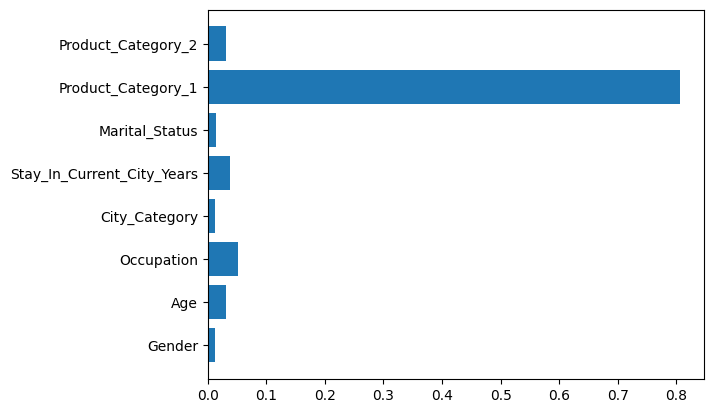

In [73]:
plt.barh(list(X.columns), rf.feature_importances_)
plt.show()

### Ada boost

In [87]:
mae_ada, mse_ada, r2_ada = [], [], []
for i in range(1,10):
    model_adaboost= ensemble.AdaBoostRegressor(estimator=tree.DecisionTreeRegressor(max_depth=i), n_estimators=100, random_state=RANDOM_STATE)
    model_adaboost.fit(x_train, y_train)
    y_predict_ada = model_adaboost.predict(x_validation)
    mae_ada.append(metrics.mean_absolute_error(y_validation, y_predict_ada))
    mse_ada.append(metrics.mean_squared_error(y_validation, y_predict_ada))
    r2_ada.append(metrics.r2_score(y_validation, y_predict_ada)) 

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  warnings.warn(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  warnings.warn(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  warnings.warn(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but AdaBoostRegresso

In [88]:
df_1 = pd.DataFrame({
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'MAE': mae_ada,
    'MSE': mse_ada,
    'R2': r2_ada
})
df_1

,max_depth,MAE,MSE,R2
0,1,3759.208505,2.516784e+07,0.007450
1,2,4000.778854,2.391237e+07,0.056962
2,3,3247.352610,1.899306e+07,0.250966
3,4,6113.621990,5.471527e+07,-1.157818
4,5,5647.594347,4.954335e+07,-0.953852
5,6,6389.964621,5.951644e+07,-1.347163
6,7,6180.436053,5.677326e+07,-1.238980
7,8,6238.909859,5.768964e+07,-1.275119
8,9,3852.465140,2.635910e+07,-0.039530


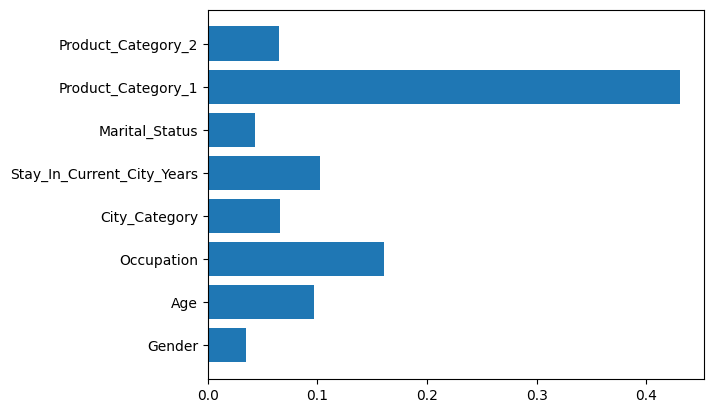

In [89]:
plt.barh(list(X.columns), model_adaboost.feature_importances_)
plt.show()

### XGBoost

In [ ]:
from xgboost import plot_importance

In [ ]:
model_XGboost = XGBRegressor(n_estimators = 1000, early_stopping_rounds=5)

In [ ]:
model_XGboost.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=False)

In [ ]:
model_XGboost = XGBRegressor(n_estimators=1000, early_stopping_rounds=5)

model_XGboost.fit(x_train, y_train,
                  eval_set=[(x_test, y_test)],  
                  verbose=False)

best_n_estimators = model_XGboost.best_iteration
print(f"Najbolji n_estimators: {best_n_estimators}")

final_XGboost = XGBRegressor(n_estimators=best_n_estimators)
final_XGboost.fit(x_train, y_train)
y_predict_XG = final_XGboost.predict(x_test)

In [ ]:
mae_xg, mse_xg, r2_xg = metrics.mean_absolute_error(y_test, y_predict_XG), metrics.mean_squared_error(y_test, y_predict_XG), metrics.r2_score(y_test, y_predict_XG)

In [ ]:
mae_xg, mse_xg, r2_xg

In [ ]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 1, 1)

importance = plot_importance(final_XGboost, ax= ax)
num_features = len(importance.get_yticklabels())  

ax.set_yticklabels(data.columns[:num_features])

ax.set_xlabel('Težina atributa')  
ax.set_ylabel('Atributa')  
ax.set_title('Važnost atributa')   

plt.show()

## Evaluacija

In [ ]:
evaluacija = {
    "Tip": ["lr", "DT", "RF", "AB", "XGB"],
    "MAE": [mae_lr, mae_dt, mae_rf, mae_ada[3], mae_xg],
    "MSE": [mse_lr, mse_dt, mse_rf, mse_ada[3], mse_xg],
    "R²": [r2_lr, r2_dt, r2_rf, r2_ada[3], r2_xg]
}

df = pd.DataFrame(evaluacija)
df.round(3)

## ZAKLJUCAK


Cilj ovog projekta jeste bio da se istrazi uticaj razlicitih faktora na potrosenu kolicinu novca tokom Black friday rasprodaja.

Formiran je linearan model, zatim stablo odlucivanje, random forest i na kraju Adaboost i XGboost.

Modeli su evaulirani, a takodje i unapredjeni odgovarajucim transformacijama nad zavisnom promenljivom i tjunovanjem parametara.

Ocekivano, dosli smo do zakljucka da je najbolji XGboost model, dok linearni model u ovom slucaju ima najslabije karakteristike.